# Report: Ex1 - ZooScanNet in the cloud

## Tore Aadland

Prior works:
http://benanne.github.io/2015/03/17/plankton.html
https://www.kaggle.com/c/datasciencebowl/discussion

First lets load required modules:

In [1]:
import numpy as np
import random as rn
from dotenv import load_dotenv
import os
from skimage import io
from skimage.transform import resize, rotate
from skimage.util import pad
import matplotlib.pyplot as plt
from keras.utils import to_categorical, plot_model

import itertools

from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import Dropout, Flatten, Dense, Input, Concatenate, Reshape, Flatten
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from sklearn.metrics import confusion_matrix
# import tensorflow as tf

import datetime
import time
import threading
load_dotenv()

Using TensorFlow backend.


True

 Then seed the random number generators to make results reproducible:

In [2]:
rn.seed(42)
np.random.seed(42)

Then load environmental variables that point to the location of folders on this instance.

In [3]:
datafolder = os.getenv("DATAFOLDER")
outputfolder = os.getenv("OUTPUTFOLDER")
imgfolder = os.path.join(datafolder, 'MiniZoo','imgs')

Need some way of propagating the size of the image that is invariant to rotations. I am unhappy about the rigidity of the default ImageDataGenerator. I make my own custom data generator. Next is code for custom datagenerators:

In [4]:
# Code from:
# https://github.com/keras-team/keras/issues/1638

class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self): # Py3
        with self.lock:
            return next(self.it)

    def next(self):     # Py2
        with self.lock:
            return self.it.next()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

# See: http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate
# For additional possible transformations.
class MyGenerators(object):
    def __init__(self, path, val_fac=0.1, batch_size=16, validation_size=64, target_size=(224,224)):
        self.path = path
        self.val_fac = val_fac
        self.batch_size = batch_size
        self.validation_size = validation_size
        self.target_size = target_size
        
        self.labels = os.listdir(path)
        self.number_labels = len(self.labels)
        self.number_label_elements = {}
        self.label_paths = {}
        self.label_len = {}
        self.images = {}
        self.labels_to_classify = []
        for i, l in enumerate(self.labels):
            self.label_paths[i] = os.path.join(self.path, l)
            self.images[i] = (os.listdir(self.label_paths[i]))
            self.label_len[i] = len(self.images[i])
        self.test_split = int(val_fac*min(self.label_len.values()))
        self.val_split = int(2*val_fac*min(self.label_len.values()))
        self.val_steps = int(self.number_labels*(self.val_split-self.test_split)/self.batch_size)
        self.val_log = []
        self.training_log = []
    
 #   def make_square(self, image, mode='constant'):
 #       max_dim = max(image.shape)
 #       pads = ((int((max_dim-image.shape[0])/2),
 #               int((max_dim-image.shape[0])/2)),
 #               (int((max_dim-image.shape[1])/2),
 #               int((max_dim-image.shape[1])/2)))
 #       if (mode=='constant'):
 #           image = pad(image,pads , mode=mode, constant_values=255)
 #       else:
 #           image = pad(image,pads , mode=mode)
 #       return resize(image, (224,224), mode=mode)

    def make_square(self, image, mode='constant'):
        if max(image.shape) > 224:
            max_dim = max(image.shape)
            #pads = ((int((max_dim-image.shape[0])/2),
            #        int((max_dim-image.shape[0])/2)),
            #        (int((max_dim-image.shape[1])/2),
            #        int((max_dim-image.shape[1])/2)))
            pads = ((0, int((max_dim-image.shape[0]))),
                (0, int((max_dim-image.shape[1]))))
            if (mode=='constant'):
                image = pad(image,pads , mode=mode, constant_values=255)
            else:
                image = pad(image,pads , mode=mode)
            return resize(image, (224,224), mode=mode)
        else:
            max_dim = 224
            pads = ((0, int((max_dim-image.shape[0]))),
                    (0, int((max_dim-image.shape[1]))))
            if (mode=='constant'):
                image = pad(image,pads , mode=mode, constant_values=255)
            else:
                image = pad(image,pads , mode=mode)
            return image# resize(image, (224,224), mode=mode)
        
    def augment_image(self, image):
        if(np.random.choice([True, False])):
            image = np.flip(image, axis=1)
        #max_dim = max(image.shape)
        #pads = ((0, int((max_dim-image.shape[0]))),
        #            (0, int((max_dim-image.shape[1])/2)))
        #image = pad(image,pads , mode='constant', constant_values=255)
        #angle = np.random.random_integers(0,359)
        #resize_var = np.random.choice([True, False])
        #image = rotate(image, angle, resize=True, mode=np.random.choice(['symmetric', 'reflect', 'wrap', 'edge']))
        return self.make_square(image, mode='constant')

    def get_statistics(self, image):
        return (max(image.shape)/1024.0, min(image.shape)/1024.0, np.sum(image==255)/(1.0*np.product(image.shape)))

    def base_generator(self, augment_image, get_random_label_and_image):
        output_list = []
        output_labels = []
        while not len(output_list) == self.batch_size:
            random_label, random_image = next(get_random_label_and_image)
            output_labels.append(random_label)
            output_list.append(os.path.join(self.label_paths[random_label], self.images[random_label][random_image]))
        output_images = [io.imread(fp) for fp in output_list]
        output_statistics = [self.get_statistics(image) for image in output_images]
        output_augmented_images = [augment_image(image).reshape(224,224,1) for image in output_images]
        return ([np.stack(output_augmented_images), 
              np.stack(output_statistics)], 
              to_categorical(np.stack(output_labels), num_classes = self.number_labels))

    def training_image_selector(self):
        while True:
            random_label = np.random.choice( self.number_labels)
            random_image = np.random.choice(range(self.val_split, self.label_len[random_label]))
            #self.training_log.append((random_label, random_image))
            yield (random_label, random_image)
    
    @threadsafe_generator
    def training_generator(self):
        it = self.training_image_selector()
        while True:
            yield self.base_generator(self.augment_image, it)

    def val_image_selector(self):
        while True:
            for random_label in range(self.number_labels):
                for random_image in range(self.test_split, self.val_split):
                    #self.val_log.append((random_label, random_image))
                    yield (random_label, random_image)
        
    
    @threadsafe_generator
    def validation_generator(self):
        it = self.val_image_selector()
        while True:
            yield self.base_generator(self.make_square, it)    
    
    def test_image_selector(self):
        while True:
            for random_label in range(self.number_labels):
                for random_image in range(self.test_split):
                    yield (random_label, random_image)
    
    @threadsafe_generator
    def test_generator(self):
        it = self.test_image_selector()
        while True:
            yield self.base_generator(self.make_square, it)    


class MySecondGenerators(MyGenerators):
    def augment_image(self, image):
        if(np.random.choice([True, False])):
            image = np.flip(image, axis=1)
        max_dim = max(image.shape)
        #pads = ((0, int((max_dim-image.shape[0]))),
        #            (0, int((max_dim-image.shape[1])/2)))
        #image = pad(image,pads , mode='constant', constant_values=255)
        #angle = np.random.random_integers(0,359)
        #resize_var = np.random.choice([True, False])
        #image = rotate(image, angle, resize=True, mode=np.random.choice(['symmetric', 'reflect', 'wrap', 'edge']))
        return self.make_square(image, mode='symmetric')
    
    def make_square(self, image, mode='symmetric'):
        if max(image.shape) > 224:
            max_dim = max(image.shape)
            pads = ((0, int((max_dim-image.shape[0]))),
                    (0, int((max_dim-image.shape[1])/2)))
            if (mode=='constant'):
                image = pad(image,pads , mode=mode, constant_values=255)
            else:
                image = pad(image,pads , mode=mode)
            return resize(image, (224,224), mode=mode)
        else:
            max_dim = 224
            pads = ((0, int((max_dim-image.shape[0]))),
                    (0, int((max_dim-image.shape[1]))))
            if (mode=='constant'):
                image = pad(image,pads , mode=mode, constant_values=255)
            else:
                image = pad(image, pads , mode=mode)
            return image# resize(image, (224,224), mode=mode)
            
@threadsafe_generator            
def make_image_generator(gen):
    while True:
        res = next(gen)
        yield res[0][0], res[1]

@threadsafe_generator
def make_stat_generator(gen):
    while True:
        res = next(gen)
        yield res[0][1], res[1]

Next is code to visualize the data provided by the custom data generators:

In [5]:
def visualize_generator(dategen):
    train_gen = dategen.training_generator()
    next(train_gen)
    validation_gen = dategen.validation_generator()

    NUMBER_LABELS = dategen.number_labels

    print("Number of validation images per class: ", dategen.val_split-dategen.test_split)
    print("Number of steps needed to go through all validation images: ", dategen.val_steps)
    
    print("Class distribution")
    plt.bar(dategen.label_len.keys(), dategen.label_len.values())
    plt.show()
    
    print("Visualize images of training generator, a quick check to see that input data is still sane:")
    plt.figure(figsize=(15,15))
    j = 1
    for i in range(9):
        (i, s), l = next(train_gen)
        for i_, s_, l_ in zip(i,s,l):
            if j > 9:
                break
            plt.subplot(3, 3, j)
            plt.imshow(i_[:,:,0], cmap="gray")
            plt.title("{}\n{}".format(np.argmax(l_), s_))
            j += 1
    plt.show()  
    
    print("Visualize images of validation generator, a quick check to see that input data is still sane:")
    plt.figure(figsize=(15,15))
    j = 1
    for i in range(9):
        (i, s), l = next(validation_gen)
        for i_, s_, l_ in zip(i,s,l):
            if j > 9:
                break
            plt.subplot(3, 3, j)
            plt.imshow(i_[:,:,0], cmap="gray")
            plt.title("{}\n{}".format(np.argmax(l_), s_))
            j += 1
    plt.show() 

Lets instanciate a generator and have a look at the data is provides:

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Number of validation images per class:  21
Number of steps needed to go through all validation images:  105
Class distribution


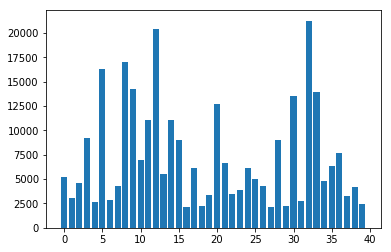

Visualize images of training generator, a quick check to see that input data is still sane:


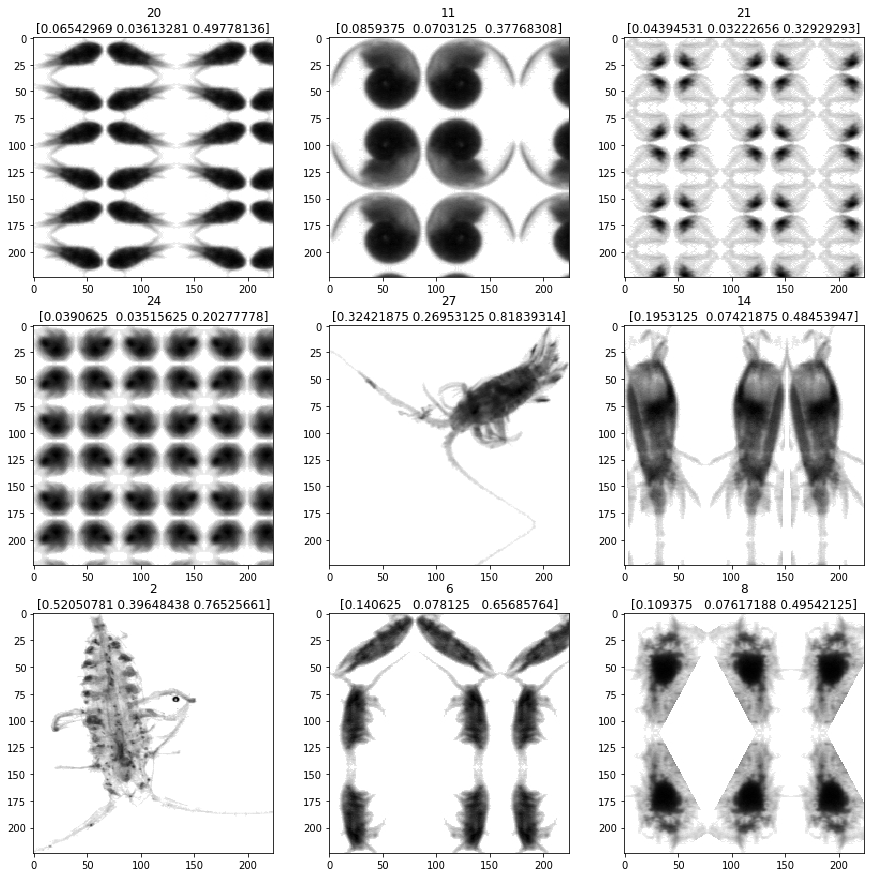

Visualize images of validation generator, a quick check to see that input data is still sane:


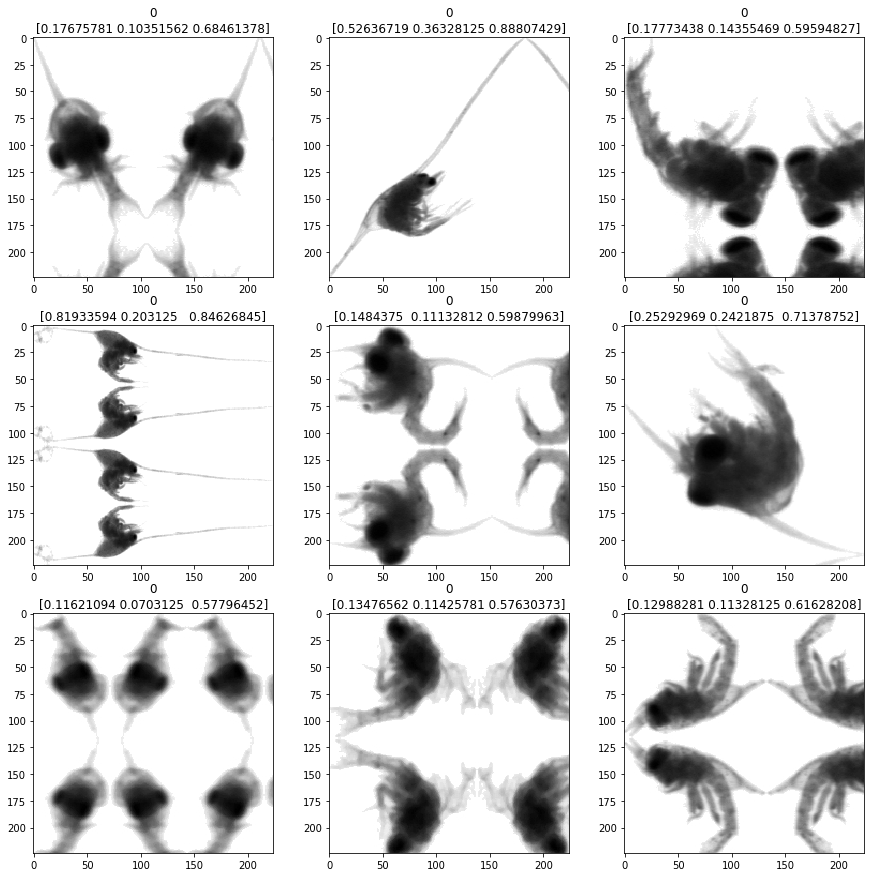

In [6]:
EPOCHS = 1
BATCH_SIZE = 8
dategen = MySecondGenerators(imgfolder, batch_size=BATCH_SIZE, val_fac=0.01)
#dategen = MyGenerators(imgfolder, batch_size=BATCH_SIZE, val_fac=0.01)
train_gen = dategen.training_generator()
validation_gen = dategen.validation_generator()
NUMBER_LABELS = dategen.number_labels
visualize_generator(dategen)

Number of validation images per class:  21
Number of steps needed to go through all validation images:  105
Class distribution


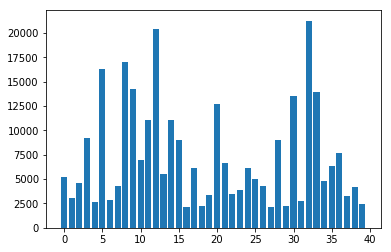

Visualize images of training generator, a quick check to see that input data is still sane:


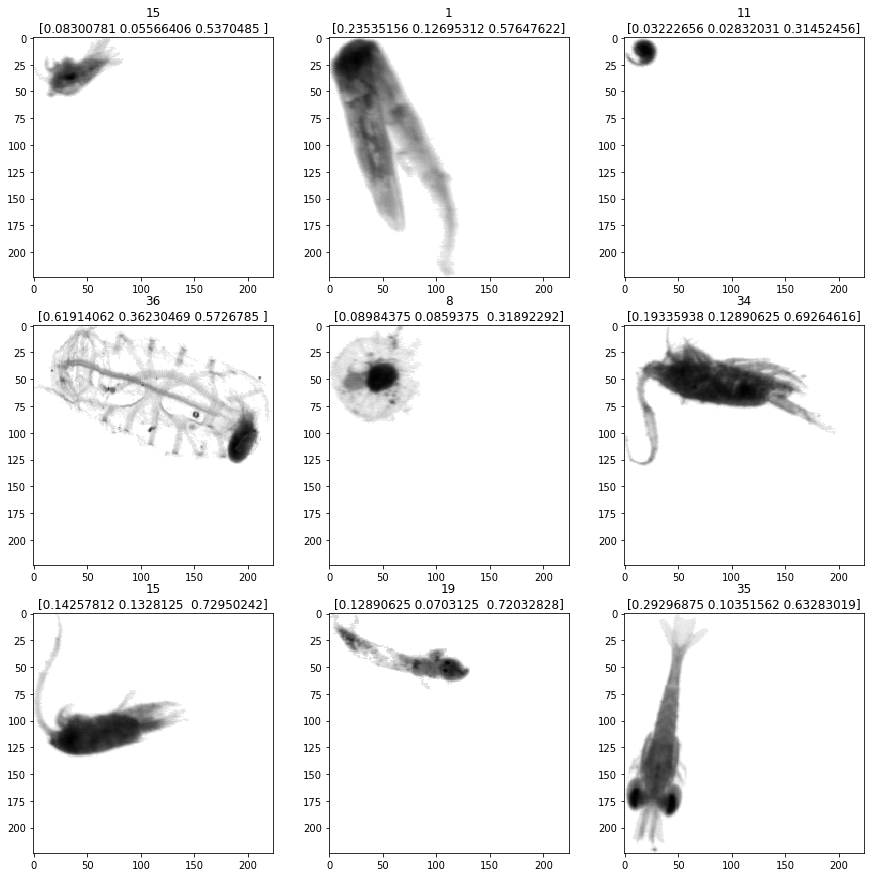

Visualize images of validation generator, a quick check to see that input data is still sane:


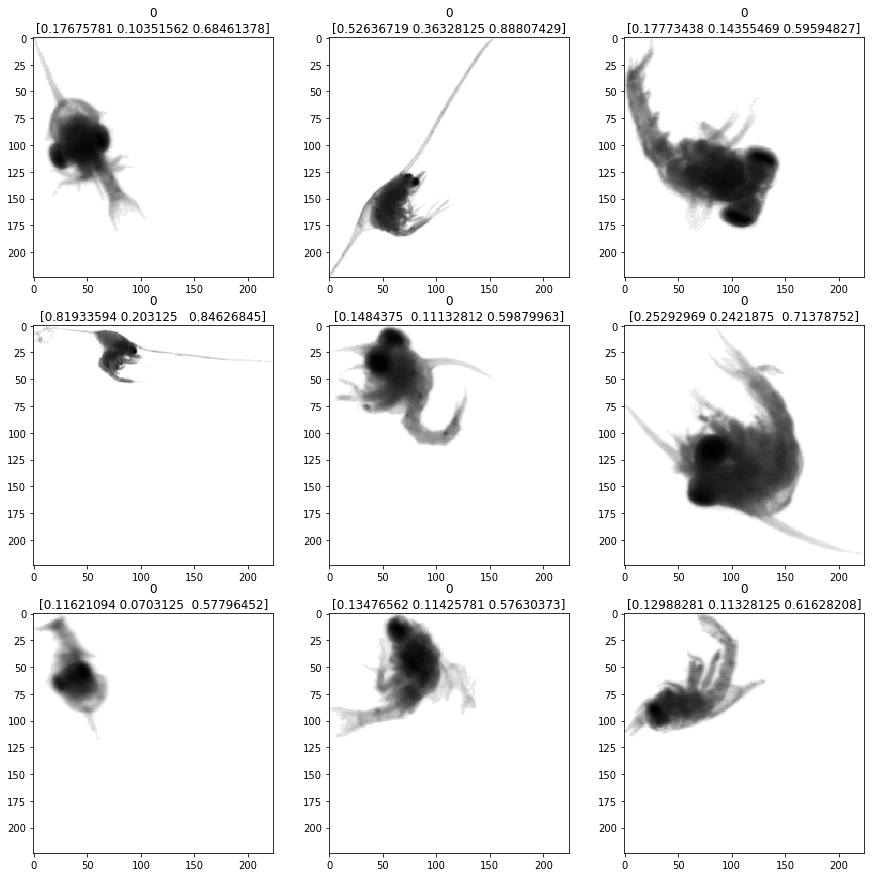

In [7]:
EPOCHS = 1
BATCH_SIZE = 8
#dategen = MySecondGenerators(imgfolder, batch_size=BATCH_SIZE, val_fac=0.01)
dategen = MyGenerators(imgfolder, batch_size=BATCH_SIZE, val_fac=0.01)
train_gen = dategen.training_generator()
validation_gen = dategen.validation_generator()
NUMBER_LABELS = dategen.number_labels
visualize_generator(dategen)

Then lets add a helper function to train and save models:

In [8]:
def fit_and_save_model(name, model, train_gen, validation_gen, 
                       steps_per_epoch = 10, validation_steps=10, epochs=10, img_input=True, patience=10, load_old_weights=False):
    modeloutputfolder = os.path.join(outputfolder, name)
    if not os.path.exists(modeloutputfolder):
        os.makedirs(modeloutputfolder)
        
    #if load_old_weights and os.path.exists(os.path.join(modeloutputfolder,'model_fitted.h5')):
    #    model = load_model(os.path.join(modeloutputfolder,'model_fitted.h5'))
    
    cbs=[#ModelCheckpoint(filepath=os.path.join(modeloutputfolder,'model_fitted.h5'), verbose=1, save_best_only=True),
         EarlyStopping(monitor='val_loss', patience=patience),
         CSVLogger(os.path.join(modeloutputfolder,'model_history.csv'), separator=',', append=False)]
         
    start_time = time.time()
    history = model.fit_generator(train_gen,
                             steps_per_epoch=steps_per_epoch,
                             validation_data=validation_gen,
                             validation_steps=validation_steps,
                             epochs=epochs, 
                            callbacks=cbs)
    end_time = time.time()
    
    
    plot_model(model, 
           to_file=os.path.join(modeloutputfolder,'model_visualized.png'),
           show_shapes=True,
           show_layer_names=True)
    
    print("It has the following training history:")
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training data loss')
    plt.plot(history.history['val_loss'], label='Validation data loss')
    plt.legend()
    plt.title("Loss")
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'], label='Training data accuracy')
    plt.plot(history.history['val_acc'], label='Validation data accuracy')
    plt.legend()
    plt.title("Accuracy")
    plt.suptitle("Model performance - {}".format(name))
    
    plt.savefig(os.path.join(modeloutputfolder,'model_history.png'))
    plt.show()
    
    score = model.evaluate_generator(validation_gen, steps=validation_steps)
    print("It has the following performance:")
    summary = "Validation loss: {}\nValidation accuracy: {}\nTraining time: {}".format(score[0], score[1], end_time-start_time)
    print(summary)
    
    with open(os.path.join(modeloutputfolder,'model_score.txt'), 'w+') as f:
        f.write(summary)

    print("It has the following confusion matrix:")
    img_vals = []
    stat_vals = []
    y_vals = []
    for _ in range(validation_steps):
        x, y = next(validation_gen)
        if len(x) == 2:
            img_vals.append(x[0])
            stat_vals.append(x[1])
        else:
            img_vals.append(x)
        y_vals.append(y)
    if stat_vals:
        X_validation = [np.concatenate(img_vals), np.concatenate(stat_vals)]
    else:
        X_validation = [np.concatenate(img_vals)]
    y_target = np.concatenate(y_vals)
    y_predicted = np.argmax(model.predict(X_validation), axis= 1)
    y_true = np.argmax(y_target, axis= 1)
    cm = confusion_matrix(y_true, y_predicted)
    for i in range(len(cm)):
        cm[i,i] = 0
    plt.figure(figsize=(15,15))
    plt.imshow(cm, cmap="Greys")
    plt.xticks(range(max(y_true+1)))
    plt.yticks(range(max(y_true+1)))
    plt.title("Confusion matrix")
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.savefig(os.path.join(modeloutputfolder,'model_confusion_matrix.png'))
    plt.show()
    
    if img_input:
        print("These are examples of misclassified features:")
        plt.figure(figsize=(15,15))
        plt.suptitle("Misclassified images - Model")
        poss_indexes = np.argwhere(y_predicted-y_true != 0)
        indexes = poss_indexes[np.random.choice(len(poss_indexes), 9)]

        for i, index in enumerate(indexes.ravel()):
            plt.subplot(3, 3, i+1)
            plt.imshow(X_validation[0][index].reshape(224,224), cmap="Greys_r")
            plt.title("A {} misclassified as {}".format(y_true[index], y_predicted[index]))
        plt.savefig(os.path.join(modeloutputfolder,'model_misclassified_features.png'))
        plt.show()

Now lets define a simple model that analyses the image statistics:

In [9]:
inputs_stat = Input(shape=(3,))
x = Dense(32, activation='relu')(inputs_stat)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output_stat = Dense(64, activation='relu')(x)
predictions_stat = Dense(NUMBER_LABELS, activation='softmax', name="output")(output_stat)
model_stat = Model(inputs=inputs_stat, outputs=predictions_stat)
model_stat.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

And a composite model that uses a pretrained model:

In [10]:
pretrained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(223,224,3))
print("The lower layer is {}".format(pretrained_model.layers[-1]))
pretrained_model.trainable = False

inputs_image_make_multi_dimensional = Input(shape=(224,224,1))
make_multi_dimensional = Conv2D(3, kernel_size=(3,3), padding='same', activation='relu')(inputs_image_make_multi_dimensional)
x = pretrained_model(make_multi_dimensional)
x = Conv2D(1, (1,1), activation='relu')(x)
outputs_pretrained = Flatten()(x)

x = Concatenate()([outputs_pretrained, output_stat])
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUMBER_LABELS, activation='softmax', name="output")(x)

composite_model_w_pretrained_model = Model(inputs=[inputs_image_make_multi_dimensional, inputs_stat], outputs=predictions)

composite_model_w_pretrained_model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

The lower layer is <keras.layers.merge.Concatenate object at 0x7fd3fdbdd588>


Lets get training. Start with the network that looks at the image statistics:

In [11]:
fit_and_save_model("model_stat", model_stat, make_stat_generator(train_gen), make_stat_generator(validation_gen),
                  steps_per_epoch = 20*dategen.val_steps, validation_steps=dategen.val_steps, patience=2, epochs=10, img_input=False)

Epoch 1/10
2100/2100 [==============================] - 52s 25ms/step - loss: 3.0556 - acc: 0.1188 - val_loss: 2.7026 - val_acc: 0.1762
Epoch 2/10
2100/2100 [==============================] - 194s 92ms/step - loss: 2.8527 - acc: 0.1618 - val_loss: 2.6216 - val_acc: 0.2167
Epoch 3/10
1923/2100 [==========================>...] - ETA: 27s - loss: 2.7868 - acc: 0.1715

KeyboardInterrupt: 

Now lets train the model with rms optimizer having the pretrained network untrainable.

In [ ]:
fit_and_save_model("composite_model_w_pretrained_model", composite_model_w_pretrained_model, train_gen, validation_gen,
                  steps_per_epoch = 20*dategen.val_steps, validation_steps=dategen.val_steps, patience=5, epochs=10)

Then lets set the pretrained network trainable and train the model using sgd optimizer

In [ ]:
pretrained_model.trainable = True
composite_model_w_pretrained_model_sgd = Model(inputs=[inputs_image_make_multi_dimensional, inputs_stat], outputs=predictions)
composite_model_w_pretrained_model_sgd.compile(optimizer='sgd', loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
fit_and_save_model("composite_model_w_pretrained_model_sgd", composite_model_w_pretrained_model_sgd, train_gen, validation_gen,
                  steps_per_epoch = 20*dategen.val_steps, validation_steps=dategen.val_steps, patience=5, epochs=10)

The one dimensional input data is made 3d by a conv2d layer with 3 filters. The 3 channel representation looks like the following:

In [ ]:
multi_dimensional_model = Model(inputs=inputs_image_make_multi_dimensional, outputs=make_multi_dimensional)
test = multi_dimensional_model.predict_generator(make_image_generator(train_gen), steps=1)
plt.figure(figsize=(15,15))
j = 1
for i in test:
    if j > 9:
        break
    plt.subplot(3, 3, j)
    plt.imshow(i/np.max(i))
    j += 1
plt.show()  

dategen = MySecondGenerators(imgfolder, batch_size=BATCH_SIZE, val_fac=0.01)
train_gen = dategen.training_generator()
validation_gen = dategen.validation_generator()
NUMBER_LABELS = dategen.number_labels
visualize_generator(dategen)

fit_and_save_model("composite_model_w_pretrained_model", composite_model_w_pretrained_model, train_gen, validation_gen,
                  steps_per_epoch = 2*dategen.val_steps, validation_steps=dategen.val_steps, epochs=EPOCHS)

In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [ ]:
#fit_and_save_model("composite_model", composite_model, train_gen, validation_gen,
#                  steps_per_epoch = 2*dategen.val_steps, validation_steps=dategen.val_steps, epochs=EPOCHS)

In [ ]:
#fit_and_save_model("model_stat", model_stat, make_stat_generator(train_gen), make_stat_generator(validation_gen),
#                  steps_per_epoch = 2*dategen.val_steps, validation_steps=dategen.val_steps, epochs=EPOCHS, img_input=False)

In [ ]:
#fit_and_save_model("model_images", model_images, make_image_generator(train_gen), make_image_generator(validation_gen),
#                  steps_per_epoch = 2*dategen.val_steps, validation_steps=dategen.val_steps, epochs=EPOCHS)